<div class="alert alert-block alert-info">
Author:<br>Felix Gonzalez, P.E. <br> Adjunct Instructor, <br> Division of Professional Studies <br> Computer Science and Electrical Engineering <br> University of Maryland Baltimore County <br> fgonzale@umbc.edu
</div>

The objective of this Jupyter Notebook is to introduce the topic of Natural Language Processing, discuss various libraries and models available and tasks that can be performed in NLP.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

import nltk # Natural Langage Toolkit
from nltk import word_tokenize, pos_tag # Tokenizer and Parts of Speech Tags
from nltk.tokenize import RegexpTokenizer # Tokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer # Lemmitization and Stemming
from nltk.corpus import stopwords, wordnet # Stopwords and POS tags
#nltk.download #(One time to download 'stopwords')
#nltk.download # (One time to download 'punkt')
#nltk.download #(One time to download 'averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer # Vectorization Functions
from sklearn.metrics import pairwise_distances # Cosine similarity

In [2]:
pd.set_option('display.max_colwidth', None) # Allows to show all the column information in a DF.

# Table of Contents

[Natural Language Processing (NLP)](#Natural-Language-Processing-(NLP))

[Data](#Data)

- [Data Loading](#Data-Loading)

[Stopwords](#Stopwords)

- [SciKit-Learn Stopwords](#SciKit-Learn-Stopwords)

- [NLTK Stopwords](#NLTK-Stopwords)

- [Custom Stopwords](#Custom-Stopwords)

[Text Normalization Functions](#Text-Normalization-Functions)

[Bag of Words (BoW) Model](#Bag-of-Words-(BoW)-Model)

[References](#References)

# Natural Language Processing (NLP)
[Return to Table of Contents](#Table-of-Contents)

Natural Language Processing (NLP) refers to the process and data transformation that a system and algorithms performs to understand and extract meaning and insights from unstructured data (e.g., text, language, etc.). In data science and artificial intelligence, NLP can be used for various tasks including but not limited classification, clustering, recommendation, ranking, question answering, text summarization, and generative (e.g., given a prompt generate text, image, sound, and video). Note that in large language model (LLM) space, these tasks are called fine-tunning.

There are various methods and models that can be applied given the task. Some methods and models from simple to complex include:
- Bag of Words (BoW) model
- Word and Sentence Embeddings (e.g., word2Vec)
- Transformers (e.g., Google BERT, Hugging Face T5)
- Large Language Models (e.g., OpenAI ChatGPT)

The amount of data needed is highly variable and dependent on the task and method used. For example, the objective of similarity ranking is to compare the similarity between two bodies of text (e.g., two paragraphs) or perhaps a query. Similarity ranking can be used with as little as two records. 

Classification tasks (i.e., sentiment analysis, predicting text category such as email category) you will need enough records for each category (e.g., SPAM and HAM emails or positive/negative sentiment) for the model to be able to predict each category.

In generative-AI and LLMs the data requirements are so large that takes a extremely large processing capacity and millions of dollars just to train a model.

Porcessing of the data and implementation of the model also varies significantly based on the methods and model used and each has its own learning curve. There are various libraries available that can be used for NLP or various steps within NLP. Anaconda includes the following libraries that have NLP components:
- NLTK
- SciKit-Learn
- Gensim

The following NLP libraries, methods, and models that currently, as of December 2023, are not included in the Anaconda Distribution and have to be installed separately.
- spaCy
- TextBlob
- ScatterText
- Bert
- Hugging Face
- OpenAI ChatGPT

This notebook discusses the BoW model which is one of the simplest models used in NLP as well as othe processing steps such as normalization. Later notebooks will cover how to use the BoW model to calculate similarity to perform a query. Similarity ranking can be used for many things including modifying the code to calculate similarity between every other question or other types of text.

# Data
[Return to Table of Contents](#Table-of-Contents)

The example dataset is a helthcare related question and anser sets. The dataset has four columns: question, answer, source and focus_area. The question and/or answer columns can be processed and the text normalized.

The question or answer columns could be used for performing similarity ranking queries or calculations. The focus_area column could be used to classify new symptoms or qeustion into its corresponding area given the qeustion or answer.

This notebook will discuss how to perform natural language processing, text normalization, develop the bag of words (BoW) model token matrix. Further notebook will provide an example of how a similarity ranking query works. Note that the same BoW matrix can also be used to perform other types of tasks like classification and clustering.   

Source of dataset: https://www.kaggle.com/datasets/jpmiller/layoutlm

### Data Loading

In [3]:
# Read dataframe.
df = pd.read_csv('./input_data/medquad.csv')

In [4]:
df

question  \
0                                                               What is (are) Glaucoma ?   
1                                                                 What causes Glaucoma ?   
2                                                    What are the symptoms of Glaucoma ?   
3                                                 What are the treatments for Glaucoma ?   
4                                                               What is (are) Glaucoma ?   
...                                                                                  ...   
16407                What is (are) Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16408               How to prevent Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16409              How to diagnose Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16410  What are the treatments for Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16411               What to do for Diabetic Neuropathies: The Nerve Damage of Diabetes ?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
df['question'].describe() # About ~15K unique questions.
# Seems that the question "What casuses Causes of Diabetes?" is repeated 20 times.
# Note that this may not necessarily be a full duplicate as the dataset has data from various sources.
# The answer to the question may be different. 

count                                16412
unique                               14984
top       What causes Causes of Diabetes ?
freq                                    20
Name: question, dtype: object

In [6]:
df['question'].describe() # About ~15K unique questions.

count                                16412
unique                               14984
top       What causes Causes of Diabetes ?
freq                                    20
Name: question, dtype: object

In [7]:
df['focus_area'].value_counts()
# Focus areas that have few counts will not be useful for classification.
# Even the top categorical value only has 53 counts and may or may not be enough data to use in classification task.

focus_area
Breast Cancer                                                           53
Prostate Cancer                                                         43
Stroke                                                                  35
Skin Cancer                                                             34
Alzheimer's Disease                                                     30
                                                                        ..
Osteogenesis imperfecta Levin type                                       1
Ichthyosis, leukocyte vacuoles, alopecia, and sclerosing cholangitis     1
Ichthyosis hystrix, Curth Macklin type                                   1
Reticuloendotheliosis                                                    1
Autosomal dominant intermediate Charcot-Marie-Tooth disease type E       1
Name: count, Length: 5126, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


# Stopwords
[Return to Table of Contents](#Table-of-Contents)

Stop words are defined as words that occur too often in the corpus and do not have significant contribution to the model, providing insights, or extracting meaning. In a language these can include words that occur too often. NLP libraries (e.g., NLTK, Scikit-learn) typically have a list of predefined stop words. NLP tools can use a list of global stop words applied during text cleaning tasks as well as could also allow users submit custom list of stop words that may be industry specific. The use of stop words (custom or otherwise) need to be documented as removing important words to the corpus may either introduce errors, biases, or give the appearance of bias.

### SciKit-Learn Stopwords
[Return to Table of Contents](#Table-of-Contents)

The list below are the list of stopwords from SciKit-learn library. Note that some words here vary from the words in NLTK library. For example, the SKLearn stopwords list includes the word "fire" which may be important when trying to search topics related to word "fire". If that is the case you will need to remove the word fire from the stopwords list.

In [9]:
from sklearn.feature_extraction import text
print(list(text.ENGLISH_STOP_WORDS))

['eleven', 'yet', 'would', 'she', 'after', 'or', 'both', 'fill', 'often', 'former', 'nine', 'everything', 'top', 'couldnt', 'for', 'fifty', 'hereupon', 'becomes', 'eight', 'other', 'how', 'whom', 'go', 'they', 'everywhere', 'is', 'seem', 'him', 'beyond', 'few', 'keep', 'could', 'several', 'these', 'must', 'hers', 'during', 'same', 'otherwise', 'mill', 'had', 'against', 'two', 'somewhere', 'into', 'per', 'anyone', 'by', 'been', 'each', 'onto', 'your', 'still', 'very', 'see', 'even', 'put', 'else', 'an', 'that', 'fire', 'ltd', 'upon', 'below', 'full', 'namely', 'have', 'towards', 'always', 'being', 'much', 'except', 'where', 'hasnt', 'himself', 'from', 'made', 'whence', 'detail', 'noone', 'too', 'nowhere', 'never', 'you', 'without', 'hundred', 'ourselves', 'might', 'meanwhile', 'cry', 'via', 'since', 'her', 'un', 'sometimes', 'themselves', 'show', 'call', 'at', 'whose', 'than', 'also', 'any', 'whoever', 'bottom', 'three', 'anything', 'please', 'twenty', 'yourself', 'someone', 'interest',

### NLTK Stopwords
[Return to Table of Contents](#Table-of-Contents)

The list below are the list of stopwords from NLTK library.

In [10]:
 print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Custom Stopwords
[Return to Table of Contents](#Table-of-Contents)

In some cases you may want to add your own set of stopwords or remove some words from the standard list. Below is an example on adding new words and removing custom stopwords. The list below is what we will use going forward in the example.

In [11]:
# STOPWORDS USED FOR SAFETY OCCURRENCE CORPUS.
# Stopwords to add need to be evaluated by a SME familiar with the corpus.
stopwords_to_add = [''] # Example: ['building', 'employee','worker']

stopwords_custom = stopwords.words('english') + [x.lower() for x in stopwords_to_add]
#print(stopwords_custom) # Comment out to see list of stopwords_custom before removing the 'no'.

# In some cases you want to consider 2-grams especially with the word no.
# For example 'no fire'.  Removing the word no from the stopwords list allows this to occur.
remove_as_stopword = ['no', 'not']
stopwords_custom = list(filter(lambda w: w not in remove_as_stopword, stopwords_custom))
print(stopwords_custom)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [12]:
# The stopword list for NLTK and SciKit learn vary.
# Recommended to review them to make sure there are no unintended consequences.
# Note that stopwords can also be called in the SciKit learn vectorization functions (e.g., TFIDFvectorizer)
# This can cause to inadvertently apply stopwords there as well.

# Text Normalization Functions
[Return to Table of Contents](#Table-of-Contents)

During text normalization various task can be performed which include but not limited to applying lower case, removing numbers and special characters, removing stop words, and applying lemmatization and/or stemming both which reduces words to their root. 

Documentation:
- NLTK Library: https://www.nltk.org/
- NLTK WordnetLemmatizer: https://www.nltk.org/_modules/nltk/stem/wordnet.html
- NLTK Porterstemmer: https://www.nltk.org/howto/stem.html

In [13]:
# Normalization of text. 
def text_normalization(text, word_reduction_method):
    text = str(text) # Convert narrative to string.
    df = pd.DataFrame({'': [text]}) # Converts narrative to a dataframe format use replace functions.
    df[''] = df[''].str.lower() # Covert narrative to lower case.
    df[''] = df[''].str.replace("\d+", " ", regex = True) # Remove numbers
    df[''] = df[''].str.replace("[^\w\s]", " ", regex = True) # Remove special characters
    df[''] = df[''].str.replace("_", " ", regex = True) # Remove underscores characters
    df[''] = df[''].str.replace('\s+', ' ', regex = True) # Replace multiple spaces with single
    text = str(df[0:1]) # Extracts narrative from dataframe.
    tokenizer = RegexpTokenizer(r'\w+') # Tokenizer.
    tokens = tokenizer.tokenize(text) # Tokenize words.
    filtered_words = [w for w in tokens if len(w) > 1 if not w in stopwords_custom] # Note remove words of 1 letter only. Can increase to higher value as needed.
    if word_reduction_method == 'Lemmatization':
        lemmatizer = WordNetLemmatizer()
        reduced_words=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words] # Lemmatization.  The second argument is the POS tag.
    if word_reduction_method == 'Stemming':
        stemmer = PorterStemmer() # Stemming also could make the word unreadable but is faster than lemmatization.
        reduced_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(reduced_words) # Join words with space.

def get_wordnet_pos(word): # Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
    #"""Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

When performing NLP, you will need to decide the target feature or column. In this case we have two columns that have unstructured data. One is the question the other is the answer. We could also combine both in one column and use that as the target. In this case we will use the question as the target. This will allow us to perform various NLP tasks within the target text or category:
- similarity calculations or ranking 
- text classification
- text clustering 

However, not that the questions tend to be really short. Before making a decision on the target it would also be good practice to explore some statistics on the number of words, lenght of the text, and any other stats that we may think of. Note below that when normalizing text data it sometimes removes all the words and we end up with a target text with no words hence no vectors. This will cause issues later on and need to be addressed (i.e., fixed or removed).

In [14]:
%%time
# Applies the normalization fuction to normalize the question column of the dataset WITHOUT stemming.
df['norm_text_wlemma'] = df['question'].apply(text_normalization, word_reduction_method = 'Lemmatization')

CPU times: total: 47.3 s
Wall time: 50.3 s


In [15]:
df.sample(1) # With norm_text_wlemma column added

,question,answer,source,focus_area,norm_text_wlemma
9585,what research (or clinical trials) is being done for Mucolipidoses ?,"The mission of the National Institute of Neurological Disorders and Stroke (NINDS) is to seek fundamental knowledge of the brain and nervous system and to use that knowledge to reduce the burden of neurological disease. Investigators are conducting studies to determine the effects of ML genetic mutations in various animal models of the disease. Studying the disease mechanisms in these models may allow scientists to develop treatments for people with an ML disorder.Clinical trials include a natural history of individuals with ML IV, to better understand the disease and identify potential outcomes, and longitudinal studies to better understand disease progression, assess current therapies, and identify potential treatments.",NINDS,Mucolipidoses,research clinical trial do mucolipidoses


In [16]:
%%time
# Applies the normalization fuction to normalize the question column of the dataset WITH stemming.
df['norm_text_wstemming'] = df['question'].apply(text_normalization, word_reduction_method = 'Stemming')

CPU times: total: 21.6 s
Wall time: 23.2 s


In [17]:
df.sample(1) # With norm_text_wstemming column added.

,question,answer,source,focus_area,norm_text_wlemma,norm_text_wstemming
10232,What are the genetic changes related to congenital adrenal hyperplasia due to 11-beta-hydroxylase deficiency ?,"Mutations in the CYP11B1 gene cause CAH due to 11-beta-hydroxylase deficiency. The CYP11B1 gene provides instructions for making an enzyme called 11-beta-hydroxylase. This enzyme is found in the adrenal glands, where it helps produce hormones called cortisol and corticosterone. Cortisol has numerous functions, such as maintaining blood sugar levels, protecting the body from stress, and suppressing inflammation. Corticosterone gets converted to the hormone aldosterone, which helps control blood pressure by maintaining proper salt and fluid levels in the body. CAH due to 11-beta-hydroxylase deficiency is caused by a shortage (deficiency) of the 11-beta-hydroxylase enzyme. When 11-beta-hydroxylase is lacking, precursors that are used to form cortisol and corticosterone build up in the adrenal glands and are converted to androgens. The excess production of androgens leads to abnormalities of sexual development, particularly in females with CAH due to 11-beta-hydroxylase deficiency. A buildup in the precursors used to form corticosterone increases salt retention, leading to hypertension in individuals with the classic form of CAH due to 11-beta-hydroxylase deficiency. The amount of functional 11-beta-hydroxylase enzyme that an individual produces typically determines the extent of abnormal sexual development. Individuals with the classic form of the condition usually have CYP11B1 gene mutations that result in the production of an enzyme with low levels of function or no function at all. Individuals with the non-classic form of the condition typically have CYP11B1 gene mutations that lead to the production of an enzyme with moderately reduced function. The severity of the signs and symptoms of sexual development do not appear to be related to the severity of the hypertension.",GHR,congenital adrenal hyperplasia due to 11-beta-hydroxylase deficiency,genetic change related congenital adrenal hyperplasia due beta hydroxylase deficiency,genet chang relat congenit adren hyperplasia due beta hydroxylas defici


Note that sometimes when normalizing text data, all the words on the text record being normalized can be removed (e.g., if all the words are stop words). This may result in issues when calculating the BoW models token vectors. We need to evaluate the issue and when it cannot be resolved we need to filter out these rows.

In [18]:
print(f'Number of null values in the norm_text_wlemma:')
print(df['norm_text_wlemma'].isnull().sum()) # Checks number of rows with null values on norm_text_wlemma column
print(df[df['norm_text_wlemma'] == ''].shape[0]) # Check number of rows with blank strings on norm_text_wlemma column 

print(f'Number of null values in the norm_text_wstemming:')
print(df['norm_text_wstemming'].isnull().sum()) # Checks number of rows with null values on norm_text_wstemming column
print(df[df['norm_text_wstemming'] == ''].shape[0]) # Check number of rows with blank strings on norm_text_wstemming column 

Number of null values in the norm_text_wlemma:
0
2
Number of null values in the norm_text_wstemming:
0
2


The cell below allows us to explore the rows that have blank columns in the norm_text columns. In this case we can see that the question seems to have an error and not complete. We need to filter out these rows.

See that it looks like there are some questions that are not complete.

In [19]:
#df[df['norm_text_wstemming'].isnull].head()
df[df['norm_text_wstemming'] == ''].head()

question  \
7885  What is (are)  ?   
8077  What is (are)  ?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [20]:
# Drops rows with null and blank norm_text columns and resets index. 

print(df.shape)
df = df[df['norm_text_wlemma'].notnull()].reset_index(drop=True)
df = df[df['norm_text_wlemma'] != ''].reset_index(drop=True)
df = df[df['norm_text_wstemming'].notnull()].reset_index(drop=True)
df = df[df['norm_text_wstemming'] != ''].reset_index(drop=True)
print(df.shape)

(16412, 6)
(16410, 6)


In [21]:
# Let's exprot this dataframe which we will use in other examples.
df.to_csv(r'.\output_data\df_norm_text.csv', encoding='utf-8-sig', 
          index = False, 
          header = True)

# Bag of Words (BoW) Model
[Return to Table of Contents](#Table-of-Contents)

The goal of the bag of words model is to convert text data to numerical data. This is accomplished by creating a matrix of every __token (e.g., word, phrases, sentences, paragraphs, etc.)__ in the corpus. The text tokens are represented in a matrix with their vector or numerical representation. The numerical representation can take various forms:
- [Count vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): which counts how many times a token occurs in the text.
- [Term-Frequency Inverse Document-Frequency (TFIDF) vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): The calculation of the token in the text is based on an equation that takes into consideration the importance of the token. The TFIDF equation is as follows:

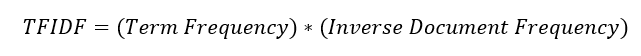

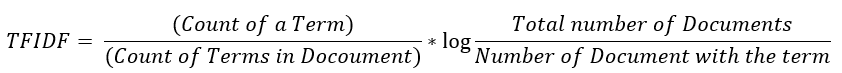

In the simple example below the document tokens are represented only in a raw count (i.e., how many times the token appears), but could be represented using other metrics such as TFIDF. The matrix created is called a [sparse matrix](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html). Exploring the statistics using the describe function allows us to see that the numbers are not 0 and explore some of the values. Each column in the matrix represents a vector for each dimension (e.g., token).

In [22]:
# Let's take the simple example BoW matrix.
df_sample_BoW_matrix = pd.read_excel('./input_data/Sample-BoW-Matrix.xlsx')
print(df_sample_BoW_matrix.shape)
df_sample_BoW_matrix

(4, 4)


,Hypothetical Text,cause,symptom,glaucoma
0,What are the causes of glaucoma?,1,0,1
1,What are the symptoms of glaucoma?,0,1,1
2,What are the causes and symptoms of glaucoma?,1,1,1
3,"Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. Some types of Glaucoma have no symptoms while in others symptoms develop over time. Causes of glaucoma my be due to age, and pressure in the eye.",1,2,3


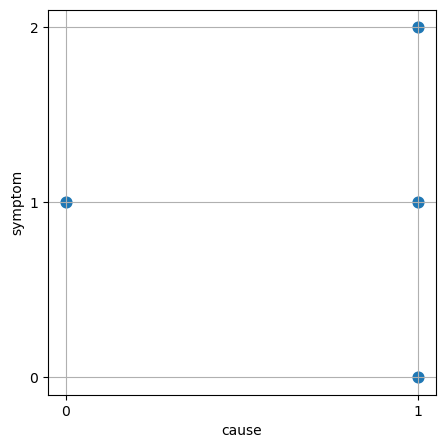

In [23]:
# Let's plot two of our dimensions:
x_values = df_sample_BoW_matrix['cause']
y_values = df_sample_BoW_matrix['symptom']

plt.figure(figsize = [5, 5])
plt.scatter(x = x_values, y = y_values, marker='o', s = 60)

plt.xlabel('cause')
plt.xticks(range(0, max(x_values)+1))
plt.ylabel('symptom')
plt.yticks(range(0, max(y_values)+1))

plt.grid() 
plt.show();
# How would be determine similarity of each of these points to the other?

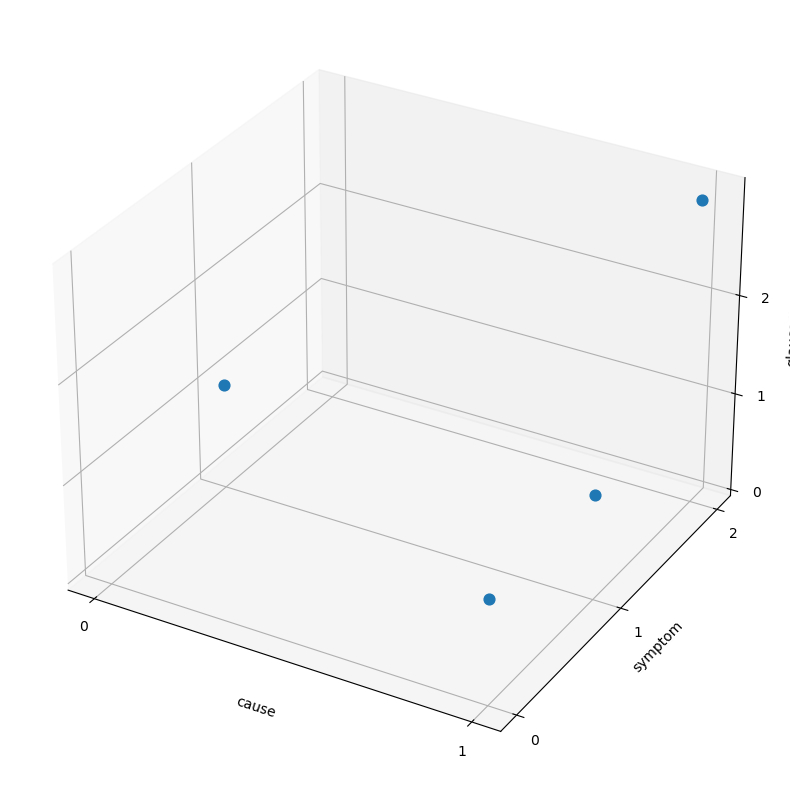

In [24]:
# Let's plot three of our dimensions. As the dimensions become more it is more difficult to visualize.
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html

x_values = df_sample_BoW_matrix['cause']
y_values = df_sample_BoW_matrix['symptom']
z_values = df_sample_BoW_matrix['glaucoma']

fig = plt.figure(figsize = [10, 10])
ax = plt.axes(projection="3d")
ax.scatter(xs = x_values, ys = y_values, zs = z_values, 
           zdir = 'z', marker='o', s = 60, depthshade=False)

ax.set_xlabel('cause')
ax.set_xticks(range(0, max(x_values)+1))

ax.set_ylabel('symptom')
ax.set_yticks(range(0, max(y_values)+1))

ax.set_zlabel('glaucoma')
ax.set_zticks(range(0, max(y_values)+1))

plt.show()

The resulting vector matrix can then used for various tasks including but not limited classification, clustering, recommendation, ranking (e.g., based on similarity), question answering, text summarization, and generative (e.g., given a prompt generate text, image, sound, and video). Note that in large language model (LLM) space, some of these tasks are called fine-tunning. 

The code below uses the scikit-learn to create each token vector (i.e., transform the text to numerical format). The standard practice is to use a term-frequency inverse docuemnt-frequence (TFIDF) vectorization. Note that there are other vectorization methods available that can be used such as CountVectorizer.

Documentation:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [25]:
# Let's go back to our health data example.
# Creating BOW for the Target DataFrame with selected Vectorizer TFIDF
# Note that CountVectorizer is another vectorization function.
# The below function defines an instance of the vectorizer with its specific parameters.
vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word', 
                             stop_words=stopwords_custom, 
                             ngram_range=(1, 2), 
                             max_df = 0.95, 
                             min_df = 0.0005
                            )

In [26]:
# Depending on which word reduction method (e.g., lemmatization, stemming) 
# you will use you need to pick the corresponding column to create the bow array.

# Lemmatized
bow_array = vectorizer.fit_transform(df['norm_text_wlemma']).toarray()

# Stemming
#bow_array = vectorizer.fit_transform(df['norm_text_wstemming']).toarray()

In [27]:
# Returns word vectors.
features = vectorizer.get_feature_names_out()
features

array(['abdominal', 'abdominal adhesion', 'abetalipoproteinemia', ...,
       'zellweger', 'zollinger', 'zollinger ellison'], dtype=object)

In [28]:
# Combining the bow_array with the tokens.
# Note that the total number of ccolumns is the number of tokens or dimensions we have.
# Note that there are some 1-grams (token composed of 1 word) and 2-grams (token composed of 2 words).
df_bow = pd.DataFrame(bow_array, columns = features)
print(df_bow.shape)
df_bow.sample(3)

(16410, 2195)


,abdominal,abdominal adhesion,abetalipoproteinemia,absence,absence va,absent,abuse,acanthocytosis,accumulation,achalasia,...,woman,woolly,woolly hair,xanthomatosis,xxyy,xxyy syndrome,young,zellweger,zollinger,zollinger ellison
12773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Let's exprot this dataframe which we will use in other examples.
df_bow.to_csv(r'.\output_data\df_bow.csv', encoding='utf-8-sig', 
              index = False, 
              header = True)

Few things to note on the above BoW matrix dataframe:
- Each row represents the tokens for the corresponding row and text in the source dataframe.
- The size of the matrix and number of tokens depends on several factors:
    - Size of unstructured data being transformed (e.g., text corpus)
    - TFIDF vectorizer parameters: stopwords, ngrams, max_df and min_df.
- Stemming is faster but the resulting tokens are not necessarily readable.
- Lemmatization is slower but the resulting tokens will be readable.
- Each token in the matrix is a dimension for a record.

The df_bow dataframe can be merged with the df based on index. Note that if the df was filtered and the index was not reset, the df_bow and the df will not align.

Once the df_bow is created the vectors for each token can be used for various tasks including but not limited to classification, clustering, similarity ranking, and other tasks or insights that may require having numeric data such as calculating statistics for specific words. Further notebooks will show how this can be performed.

In [30]:
# This code here combines bot the df and df_bow in one dataframe.
pd.concat([df, df_bow], axis=1)

question  \
0                                                               What is (are) Glaucoma ?   
1                                                                 What causes Glaucoma ?   
2                                                    What are the symptoms of Glaucoma ?   
3                                                 What are the treatments for Glaucoma ?   
4                                                               What is (are) Glaucoma ?   
...                                                                                  ...   
16405                What is (are) Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16406               How to prevent Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16407              How to diagnose Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16408  What are the treatments for Diabetic Neuropathies: The Nerve Damage of Diabetes ?   
16409               What to do for Diabetic Neuropathies: The Nerve Damage of Diabetes ?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# References
[Return to Table of Contents](#Table-of-Contents)

Guide for dealing with text data predictive in Python: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

Lemmatization and Stemming
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
- https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/
- https://212digital.medium.com/what-is-lemmatization-and-stemming-in-nlp-e25e142332c4

# NOTEBOOK END